output layer =2
use cross entropy loss
use argmax to obtain predicted values

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


Calculating the distance using haversine formula

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
   
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [6]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


Processing the timestamp data and obtaining categorical labels

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [8]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km'],
      dtype='object')

In [9]:
df['EDTDate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['Hour'] = df['EDTDate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] > 12 , 'pm','am')
df['Weekday'] = df['EDTDate'].dt.strftime("%a")

Separating the categorical, continuous and output columns. Categorize the categorical ones

In [10]:
cat_cols = ['Hour','AMorPM','Weekday']
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'dist_km']
y_col = ['fare_class']

In [11]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [12]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
weekday = df['Weekday'].cat.codes.values

cats = np.stack([hr,ampm,weekday],1)
cats = torch.tensor(cats, dtype = torch.int64)

In [13]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts = torch.tensor(conts,dtype = torch.float)

### !!!! Important for cross-entropy
Note: the CrossEntropyLoss function we'll use below expects a 1d y-tensor, so we'll replace <tt>.reshape(-1,1)</tt> with <tt>.flatten()</tt> this time.

flatten() returns the copy of the input array in 1 dimension

In [51]:
y = torch.tensor(df[y_col].values).flatten()

In [52]:
y

tensor([0, 0, 1,  ..., 1, 0, 0])

In [53]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [54]:
class TabularModel(nn.Module):

    def __init__(self,emb_szs,n_cont,out_size,layers,p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_cont + n_emb

        for i in layers:
            layer_list.append(nn.Linear(n_in,i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i
        
        layer_list.append(nn.Linear(layers[-1],out_size))

        self.layers = nn.Sequential(*layer_list)

    def forward(self,x_cat,x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)

        x_cont = self.batch_norm(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)

        return x

In [55]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],2,[200,100],p=0.5)

In [56]:
model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.01)

Train test splits

In [58]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [59]:
len(cat_train)

48000

In [60]:
len(cat_test)

12000

Training the model

In [61]:
losses = []
epochs = 100

for i in range(epochs):
    i += 1
    y_pred = model(cat_train,con_train)
    loss = criterion(y_pred,y_train)
    losses.append(loss.item())
    if i%10 == 0:
        print(f'Epoch:{i} loss:{loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch:10 loss:0.6232612729072571
Epoch:20 loss:0.6469186544418335
Epoch:30 loss:0.5338454842567444
Epoch:40 loss:0.3075760304927826
Epoch:50 loss:0.292965292930603
Epoch:60 loss:0.27715882658958435
Epoch:70 loss:0.27080610394477844
Epoch:80 loss:0.26865383982658386
Epoch:90 loss:0.2671998143196106
Epoch:100 loss:0.2663172483444214


Plotting the loss

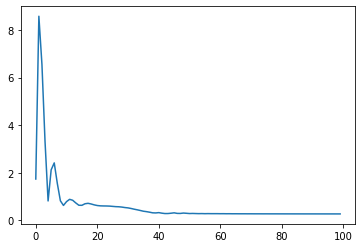

In [63]:
plt.plot(range(epochs),losses)

Evaluating the model

In [64]:
with torch.no_grad():
    y_pred = model(cat_test,con_test)
    loss = criterion(y_pred,y_test)

print(f'Training loss:{loss}')



Training loss:0.25839176774024963


Checking the first 50 predictions

In [66]:
rows = 50
correct = 0

for i in range(rows):
    print(f'Prediction: {y_pred[i]} Predicted class:{y_pred[i].argmax()} Actual Class:{y_test[i]}')

    if y_pred[i].argmax() == y_test[i]:
        correct += 1

print(f'Out of {rows} data points {correct} correct predictions were obtained')

Prediction: tensor([ 3.1060, -1.6553]) Predicted class:0 Actual Class:0
Prediction: tensor([-2.3864,  1.6021]) Predicted class:1 Actual Class:0
Prediction: tensor([ 1.6926, -0.7461]) Predicted class:0 Actual Class:0
Prediction: tensor([-1.5612,  1.4260]) Predicted class:1 Actual Class:1
Prediction: tensor([ 2.7836, -1.4214]) Predicted class:0 Actual Class:0
Prediction: tensor([ 2.3990, -1.2171]) Predicted class:0 Actual Class:0
Prediction: tensor([ 2.7711, -1.4425]) Predicted class:0 Actual Class:0
Prediction: tensor([-2.3119,  1.5563]) Predicted class:1 Actual Class:1
Prediction: tensor([ 2.6438, -1.3590]) Predicted class:0 Actual Class:0
Prediction: tensor([-0.6992,  0.8467]) Predicted class:1 Actual Class:1
Prediction: tensor([ 2.3256, -1.1679]) Predicted class:0 Actual Class:0
Prediction: tensor([ 2.2319, -1.0643]) Predicted class:0 Actual Class:0
Prediction: tensor([ 1.8216, -0.7932]) Predicted class:0 Actual Class:0
Prediction: tensor([-1.4063,  1.3231]) Predicted class:1 Actual 

Saving the model

In [67]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareClssModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

Obtaining Single prediction

In [68]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts).argmax().item()
    print(f'\nThe predicted fare class is {z}')